## Assignment for inloop - Ronen Fischer

The assignment will be combined with a presentation/project description, to be able to explain step by step what is done and what are the tools and methods that are used in every step.

## Data ingestion

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
import numpy as np
import itertools
import os

In [215]:
## Reading both data sets into pandas data frames
train =  pd.read_csv('C:\\Users\\Public\\Ronen\\TrainDataset.csv')
test =  pd.read_csv('C:\\Users\\Public\\Ronen\\\\TestDataset.csv')
datasets = [train,test]

## Data exploration/Understanding

In [216]:
# Take a quick look at the data frame
train.head()

,_id,articleId,customerName,isCategory,nGramCnt,origCount,origSentence,scores.betweeness,scores.closeness,scores.degree,...,scores.load,scores.originalPhrase,scores.relDocsRatio,scores.relTermsRatio,scores.relVsIrrelDocs,scores.relVsIrrelTerms,scores.relevance,stem,stemCount,termOccurrence
0,5ac21b66fffa7600087418f6,109790,MIT_AthleticTrainers,0,2,NaN,Head Coach,0.347311,2.377348,1.548673,...,0.347311,Head Coach,0.393498,0.327344,0.648799,0.486644,0.309237,head coach,NaN,2
1,5ac21b67fffa7600087418f7,109790,MIT_AthleticTrainers,0,2,NaN,Kelly Sheffield,NaN,NaN,1.548673,...,NaN,Kelly Sheffield,1.000000,1.000000,1.000000,1.000000,0.286234,kelli sheffield,NaN,2
2,5ac21b67fffa7600087418f8,109790,MIT_AthleticTrainers,0,1,NaN,MPH,0.241352,NaN,NaN,...,0.241352,MPH,0.428571,0.434466,0.750000,0.768240,0.239319,mph,NaN,2
3,5ac21b67fffa7600087418f9,109790,MIT_AthleticTrainers,0,2,NaN,National Championship,0.347311,2.377348,1.548673,...,0.347311,National Championships,0.406593,0.385542,0.685185,0.627451,0.302010,nation championship,NaN,2
4,5ac21b67fffa7600087418fa,109790,MIT_AthleticTrainers,0,2,NaN,Revolutionary Radar,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.519455,revolutionari radar,NaN,2


In [217]:
print(train.shape)
print(test.shape)

(1713, 32)
(854, 32)


In a first glance, we see that there are a lot of null values we need to handle before we even start to explore our features. Let's see how many values are there and then think of how to deal with them

In [218]:
train.isnull().any()

_id                       False
articleId                 False
customerName              False
isCategory                False
nGramCnt                  False
origCount                  True
origSentence              False
scores.betweeness          True
scores.closeness           True
scores.degree              True
scores.fromBegScore       False
scores.isInTag-a           True
scores.isInTag-b           True
scores.isInTag-h1          True
scores.isInTag-h2          True
scores.isInTag-h3          True
scores.isInTag-h4          True
scores.isInTag-h5          True
scores.isInTag-h6          True
scores.isInTag-i           True
scores.isInTag-strong      True
scores.isInTitle           True
scores.load                True
scores.originalPhrase      True
scores.relDocsRatio        True
scores.relTermsRatio       True
scores.relVsIrrelDocs      True
scores.relVsIrrelTerms     True
scores.relevance           True
stem                      False
stemCount                  True
termOccu

looks like we have a lot of null values. let's see how many

In [219]:
train.isnull().sum()

_id                          0
articleId                    0
customerName                 0
isCategory                   0
nGramCnt                     0
origCount                 1469
origSentence                 0
scores.betweeness         1187
scores.closeness          1255
scores.degree             1023
scores.fromBegScore          0
scores.isInTag-a          1643
scores.isInTag-b          1713
scores.isInTag-h1         1712
scores.isInTag-h2         1691
scores.isInTag-h3         1677
scores.isInTag-h4         1709
scores.isInTag-h5         1708
scores.isInTag-h6         1713
scores.isInTag-i          1702
scores.isInTag-strong     1624
scores.isInTitle          1560
scores.load               1187
scores.originalPhrase      843
scores.relDocsRatio        297
scores.relTermsRatio       297
scores.relVsIrrelDocs      297
scores.relVsIrrelTerms     297
scores.relevance            72
stem                         0
stemCount                 1469
termOccurrence               0
dtype: i

So many null values. But does it make the columns with them unnecessary? Let's see. I am going to take all those columns with over 50% of null values, and see try to understand what if the data means something

In [220]:
nulls = []
for column in train.columns:
    if train[column].isnull().sum() > np.round(train.shape[0]/2):
        nulls.append(column)
nullsdf = train[nulls]
nullsdf.describe()

,origCount,scores.betweeness,scores.closeness,scores.degree,scores.isInTag-a,scores.isInTag-b,scores.isInTag-h1,scores.isInTag-h2,scores.isInTag-h3,scores.isInTag-h4,scores.isInTag-h5,scores.isInTag-h6,scores.isInTag-i,scores.isInTag-strong,scores.isInTitle,scores.load,stemCount
count,244.000000,526.000000,458.000000,690.000000,70.0,0.0,1.0,22.0,36.0,4.0,5.0,0.0,11.0,89.0,153.0,526.000000,244.000000
mean,1.680328,0.442651,2.139564,1.438155,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,0.442651,2.000000
std,1.444538,1.127035,1.714234,1.017373,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.127035,1.954208
min,1.000000,0.004507,0.259663,0.126279,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,0.004507,1.000000
25%,1.000000,0.104764,1.149301,0.850159,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,0.104764,1.000000
50%,1.000000,0.201894,1.756209,1.184043,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,0.201894,1.000000
75%,2.000000,0.406597,2.534773,1.683750,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,0.406597,2.000000
max,11.000000,12.772134,14.950779,13.207547,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,12.772134,14.000000


Now that we see the data, and we know how many missing values there are, and we may want to visualize the data before we decide how to fill these missing values. The boolean values are unnecessary to check, but let's see if the distribution of other parameters can give us some additional information as for how to fill in the values.

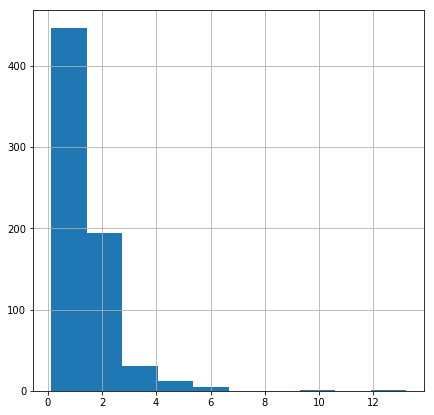

In [221]:
%matplotlib inline
train['scores.degree'].hist(figsize=(7,7))

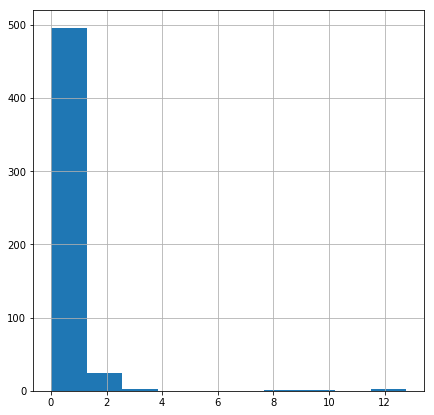

In [222]:
train['scores.betweeness'].hist(figsize=(7,7))

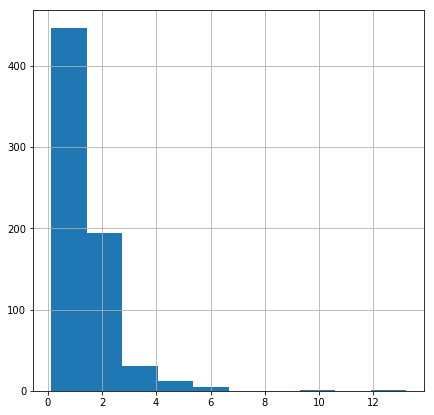

In [223]:
train['scores.degree'].hist(figsize=(7,7))

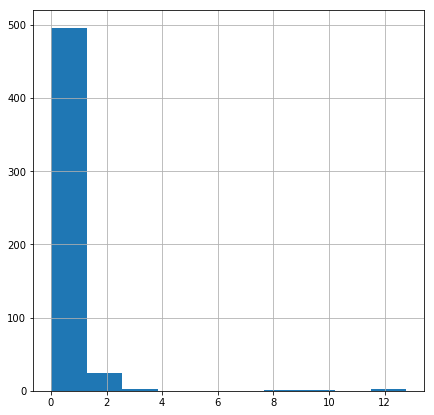

In [224]:
train['scores.load'].hist(figsize=(7,7))

This description provides us with few interesting insights:
1. Most of the tag related columns are boolean. Even through there are too many null values, their results can be changed to boolean output (1 or 0) so we don't lose information. 
2. There are rows with no values. These can be removed
3. Some columns (like scores betweeness for example) appear to be a calculation of the values in other columns)
4. On those values which are not boolean, we need to explore further, as we can tell by the standard deviation and the maximum, that there are outliers that need to be looked at

In [225]:
# This function will replace null values in our discrete columns
def fill_discrete(df):
    for column in df.select_dtypes(include = [np.number]).columns:
            if df[column].isnull().sum()==df[column].size:
                df.drop(column, axis=1,inplace = True)
            elif   (df[column].max()==df[column].mean()) and (df[column].max() ==1): #If the max and the mean are 1, then this is a boolean column
                df[column].replace(np.NaN,0,inplace = True)
    return df
for df in datasets:
    df = fill_discrete(df) # Apply function on both data sets
print(train.shape) # let's see if we lost rows
train.isnull().sum()

(1713, 30)


_id                          0
articleId                    0
customerName                 0
isCategory                   0
nGramCnt                     0
origCount                 1469
origSentence                 0
scores.betweeness         1187
scores.closeness          1255
scores.degree             1023
scores.fromBegScore          0
scores.isInTag-a             0
scores.isInTag-h1            0
scores.isInTag-h2            0
scores.isInTag-h3            0
scores.isInTag-h4            0
scores.isInTag-h5            0
scores.isInTag-i             0
scores.isInTag-strong        0
scores.isInTitle             0
scores.load               1187
scores.originalPhrase      843
scores.relDocsRatio        297
scores.relTermsRatio       297
scores.relVsIrrelDocs      297
scores.relVsIrrelTerms     297
scores.relevance            72
stem                         0
stemCount                 1469
termOccurrence               0
dtype: int64

In [226]:
# let's look at the other rows with null values and try to characterise them
nulls = []
for column in train.select_dtypes(include= [np.number]).columns:
    if train[column].isnull().sum() > 0:
        nulls.append(column)
nullsdf = train[nulls]
nullsdf.describe()

,origCount,scores.betweeness,scores.closeness,scores.degree,scores.load,scores.relDocsRatio,scores.relTermsRatio,scores.relVsIrrelDocs,scores.relVsIrrelTerms,scores.relevance,stemCount
count,244.000000,526.000000,458.000000,690.000000,526.000000,1416.000000,1416.000000,1416.000000,1416.000000,1641.000000,244.000000
mean,1.680328,0.442651,2.139564,1.438155,0.442651,0.621026,0.631783,2.995563,3.738472,0.534855,2.000000
std,1.444538,1.127035,1.714234,1.017373,1.127035,0.243266,0.255053,6.019295,7.236903,0.189141,1.954208
min,1.000000,0.004507,0.259663,0.126279,0.004507,0.000000,0.000000,0.000000,0.000000,0.205097,1.000000
25%,1.000000,0.104764,1.149301,0.850159,0.104764,0.454479,0.441856,0.833111,0.791653,0.389984,1.000000
50%,1.000000,0.201894,1.756209,1.184043,0.201894,0.600000,0.627594,1.270293,1.472088,0.521873,1.000000
75%,2.000000,0.406597,2.534773,1.683750,0.406597,0.809943,0.840467,3.256410,4.000000,0.667901,2.000000
max,11.000000,12.772134,14.950779,13.207547,12.772134,1.000000,1.000000,78.000000,108.000000,0.998230,14.000000


By looking at the summary of these columns statistics, we can see a very interesting pattern where the max value is extremely far from the mean. In most cases, it is over 6 standard deviations away. Let's try to visualize that

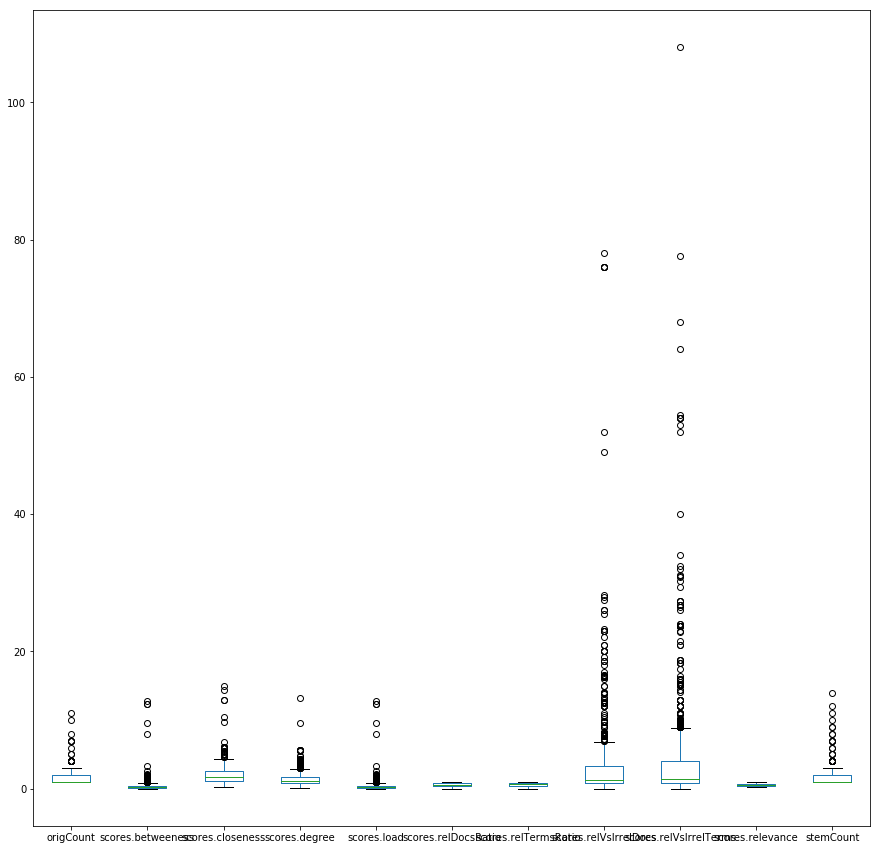

In [227]:
% matplotlib inline
nullsdf.plot(kind= 'box', figsize=(15,15))

So let's try to filter our outliers. Let's see which observations are over 6 std from the mean

In [228]:
def outliers_mapping(df):
    frames = []
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        mask = df[column]> mean + 6*std
        frames.append(df[mask])
    tmp = pd.concat(frames)
    return tmp
outliers_mapping(nullsdf)

,origCount,scores.betweeness,scores.closeness,scores.degree,scores.load,scores.relDocsRatio,scores.relTermsRatio,scores.relVsIrrelDocs,scores.relVsIrrelTerms,scores.relevance,stemCount
1418,11.0,NaN,NaN,NaN,NaN,0.780294,0.813253,3.551532,4.354839,0.606255,12.0
460,NaN,7.916355,14.364447,9.615385,7.916355,NaN,NaN,NaN,NaN,0.376511,NaN
1041,NaN,12.336720,12.976148,5.660377,12.336720,0.619864,0.729939,1.630639,2.702861,0.454816,NaN
1042,NaN,9.506531,10.420240,5.660377,9.506531,0.270677,0.294545,0.371134,0.417526,0.239050,NaN
1044,NaN,12.336720,12.976148,5.660377,12.336720,0.669697,0.734988,2.027523,2.773414,0.295051,NaN
1045,NaN,12.772134,14.950779,5.660377,12.772134,0.375897,0.375133,0.602299,0.600340,0.296800,NaN
460,NaN,7.916355,14.364447,9.615385,7.916355,NaN,NaN,NaN,NaN,0.376511,NaN
1041,NaN,12.336720,12.976148,5.660377,12.336720,0.619864,0.729939,1.630639,2.702861,0.454816,NaN
1044,NaN,12.336720,12.976148,5.660377,12.336720,0.669697,0.734988,2.027523,2.773414,0.295051,NaN
1045,NaN,12.772134,14.950779,5.660377,12.772134,0.375897,0.375133,0.602299,0.600340,0.296800,NaN


We see that there are duplicates, and more than one. Let's try to find a connection

In [229]:
outliers_mapping(nullsdf).drop_duplicates()

,origCount,scores.betweeness,scores.closeness,scores.degree,scores.load,scores.relDocsRatio,scores.relTermsRatio,scores.relVsIrrelDocs,scores.relVsIrrelTerms,scores.relevance,stemCount
1418,11.0,NaN,NaN,NaN,NaN,0.780294,0.813253,3.551532,4.354839,0.606255,12.0
460,NaN,7.916355,14.364447,9.615385,7.916355,NaN,NaN,NaN,NaN,0.376511,NaN
1041,NaN,12.336720,12.976148,5.660377,12.336720,0.619864,0.729939,1.630639,2.702861,0.454816,NaN
1042,NaN,9.506531,10.420240,5.660377,9.506531,0.270677,0.294545,0.371134,0.417526,0.239050,NaN
1044,NaN,12.336720,12.976148,5.660377,12.336720,0.669697,0.734988,2.027523,2.773414,0.295051,NaN
1045,NaN,12.772134,14.950779,5.660377,12.772134,0.375897,0.375133,0.602299,0.600340,0.296800,NaN
1043,NaN,1.015965,9.703504,13.207547,1.015965,1.000000,1.000000,3.000000,7.000000,0.963302,NaN
336,1.0,NaN,NaN,NaN,NaN,0.987013,0.981818,76.000000,54.000000,0.661451,1.0
339,1.0,NaN,NaN,NaN,NaN,0.987342,0.990826,78.000000,108.000000,0.602175,1.0
629,1.0,NaN,NaN,NaN,NaN,0.987013,0.981818,76.000000,54.000000,NaN,1.0


We can see that somehow, the outliers are correlated. The outliers of the of the irrelevance indicators are aligned (meaning that the two values are extremely high in the same observation). For that reason, I will not remove them, but rather leave them and will check correlation later on.

In [230]:
train.isnull().sum()

_id                          0
articleId                    0
customerName                 0
isCategory                   0
nGramCnt                     0
origCount                 1469
origSentence                 0
scores.betweeness         1187
scores.closeness          1255
scores.degree             1023
scores.fromBegScore          0
scores.isInTag-a             0
scores.isInTag-h1            0
scores.isInTag-h2            0
scores.isInTag-h3            0
scores.isInTag-h4            0
scores.isInTag-h5            0
scores.isInTag-i             0
scores.isInTag-strong        0
scores.isInTitle             0
scores.load               1187
scores.originalPhrase      843
scores.relDocsRatio        297
scores.relTermsRatio       297
scores.relVsIrrelDocs      297
scores.relVsIrrelTerms     297
scores.relevance            72
stem                         0
stemCount                 1469
termOccurrence               0
dtype: int64

To finish with our data cleaning, after we learned the patterns of the data, we will create a function that does the following:
1. If the values are any type of row that is a count of items, nulls will be 0
2. In case the max is value is not 0 , I will fill the values with the mean value, so the variance of the column will remain the same and will not affect the modeling process

In [231]:
def final_cleanup(df):
    for column in df.select_dtypes(include = [np.number]).columns:
        if df[column].isnull().sum()>0:
            if 'count'in column or 'Count' in column:
                df[column].replace(np.NaN , 0 , inplace = True)
            elif 'score' in column:
                    df[column].replace(np.NaN,df[column].mean(), inplace = True)
    return df
for df in datasets:
    df = final_cleanup(df)

train.isnull().sum()
        

_id                         0
articleId                   0
customerName                0
isCategory                  0
nGramCnt                    0
origCount                   0
origSentence                0
scores.betweeness           0
scores.closeness            0
scores.degree               0
scores.fromBegScore         0
scores.isInTag-a            0
scores.isInTag-h1           0
scores.isInTag-h2           0
scores.isInTag-h3           0
scores.isInTag-h4           0
scores.isInTag-h5           0
scores.isInTag-i            0
scores.isInTag-strong       0
scores.isInTitle            0
scores.load                 0
scores.originalPhrase     843
scores.relDocsRatio         0
scores.relTermsRatio        0
scores.relVsIrrelDocs       0
scores.relVsIrrelTerms      0
scores.relevance            0
stem                        0
stemCount                   0
termOccurrence              0
dtype: int64

The column scores.originalPhrase is a string that resembles the original phrase and contains no score, therefor should be dropped. The customer is also irrelevant since it is just the one value. We can also drop the phrases and their stamming since they will contribute nothing for the model ( the calculations done on these phrases are what interests us). 
We will set the index to be the article ID and use the encoder to encode the article ID

In [232]:
to_drop = ['customerName','stem' , 'scores.originalPhrase' , 'origSentence' ,'_id' ]
def prepareds(df):
    df.drop(to_drop,axis=1,inplace=True)
#     le = LabelEncoder()
#     df['_id'] = le.fit_transform(df['_id'])
    return df
for df in datasets:
    df = prepareds(df)

We have dealt with our missing values. now let's see if the data in the table is correlated using a correlation matrix. Maybe some of the data is not really needed?

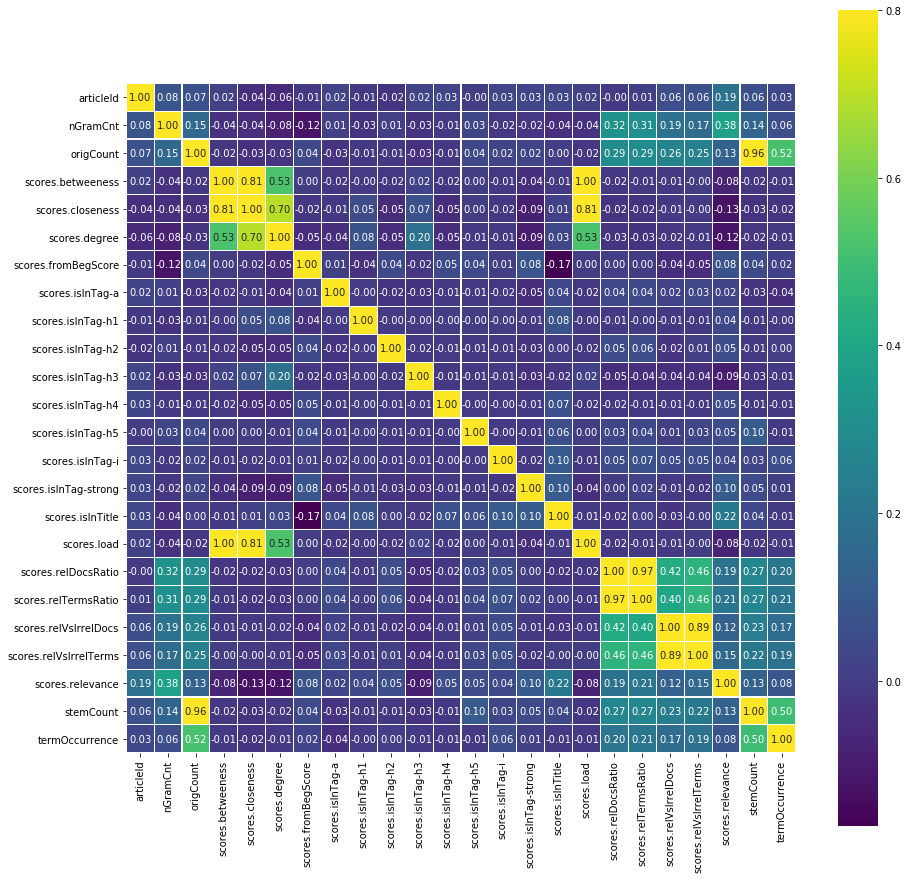

In [233]:
## checking correlations between variables
% matplotlib inline
corr = train.drop('isCategory',axis=1).corr()
colormap = plt.cm.viridis
fig = plt.figure(figsize =(15,15))
sns.heatmap(corr,vmax=0.8,cmap=colormap,annot=True,fmt='.2f',square=True,annot_kws={'size':10},linecolor='white',linewidths=0.1)

Following the correlation matrix, it seems that some features are unnecessary and can be removed. This data set is not so big, but had it been a larger one, it would have been a must

In [234]:
def tooCorrelated(df):
    suspected_rows =[]
    names = list(corr.columns)
    for i in range(corr.shape[0]):
        for j in range(i):
                   if corr.iloc[i,j]>0.9:
                    suspected_rows.append(corr.columns.get_values()[i])
                    j=i
    return suspected_rows
train.drop(tooCorrelated(train),axis=1,inplace=True)
test.drop(tooCorrelated(train),axis=1,inplace=True)

## Modeling

Now that our data set is ready, we will go to the modeling process. I will try to optimize few classification models, such as logistic regression, K nearest neighbours, decision tree, random forest and XGboost.
I will optimize the values using gridsearchcv and will test the scores of each model.

In [236]:
# SVC(probability=True, random_state=3):{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
# SVC(probability=True, random_state=3): {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
#preparing all the models to be tested
models = ['Decision Tree' , 'Logistic Regression'  ,'Random Forest', 'KNN','XGBoost','SVM-Linear']
classifiers ={DecisionTreeClassifier(max_leaf_nodes=15) : {} ,
LogisticRegression(random_state=3):{'C':[0.8,0.9,1],'penalty':['l1','l2']},
RandomForestClassifier(random_state=3):   {'n_estimators':[100],
            'max_depth':[10],
            'max_features':[0.75],
            'min_samples_split':[11]},
KNeighborsClassifier():{'n_neighbors':range(15,30), 
              'p':[1,2],
              'weights':['uniform','distance']},
xgb.XGBClassifier():{'n_estimators':[900,1000,1100],
            'learning_rate':[0.01],
            'max_depth':[8],
            'min_child_weight':[1],
            'subsample':[0.8],
            'colsample_bytree':[0.3,0.4,0.5]}, LinearSVC(random_state = 3) : { 'C':[0.8,0.9,1]}}

In [237]:
# Let's split the dataset into train and test, then scale them using standard scaler
# splitting the dataset
y=train['isCategory'] #Scaling the data,Splitting the training set into train and test set 
X=train.drop('isCategory',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=324)
X = StandardScaler().fit_transform(X)

In [238]:
y_test.value_counts()

0    396
1     33
Name: isCategory, dtype: int64

In [239]:
def fit_best_model(model,parameters,X_train,y_train):
    clf = GridSearchCV(estimator = model,param_grid = parameters,cv=5, scoring="roc_auc", n_jobs= -1)
    clf.fit(X_train,y_train)
    print ("--------------The model's accuracy is: %.5f " % clf.best_score_)
    model_score = clf.best_score_
    estimator = clf.best_estimator_
    results = (estimator,model_score)
    return results

In [240]:
def confusionMatrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # Issuing the image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "Blue")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Not the main subject','main subject']
plt.show()

In [241]:
def predictions(class_name,estimator,X_train,X_test,y_train,y_test, feature_imp=False):
    model=estimator.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("----------------The Prediction's accuracy is: %.5f "  %accuracy_score(y_test,y_pred) )
    cm = confusion_matrix(y_test,y_pred)
    titles = 'Confusion Matrix of model %s'%class_name
    confusionMatrix(cm, classes=class_names, title='Confusion matrix')
    Precision = cm[1,1]/(cm[1,1]+ cm[1,0])
     # feature importance 
    if feature_imp:
        
        feat_imp = pd.Series(estimator.feature_importances_,index=X_train.columns)
        feat_imp = feat_imp.nlargest(15).sort_values()
        plt.figure()
        feat_imp.plot(kind="barh",figsize=(10,10),title="Most Important Features")
    plt.show()
    return [accuracy_score(y_test,y_pred),Precision]

In [242]:
def scoreboard(models, classifiers, X_train, X_test, y_train, y_test):
    modeling_res = {}
    estimators ={}
    for model , classifier in zip(models,classifiers.keys()):
        results = []
        print(model)
        clf = fit_best_model(classifier,classifiers[classifier],X_train,y_train)[0]
        estimators.update({model: clf})
        results.append(fit_best_model(classifier,classifiers[classifier],X_train,y_train)[1])
        imp = False
        if model in ['Decision Tree','Random Forest', 'XGBoost'] :
              imp = True
#         results.append(predictions(model,clf,X_train,X_test,y_train,y_test, feature_imp = imp)) 
        modeling_res.update({model:predictions(model,clf,X_train,X_test,y_train,y_test, feature_imp = imp)})
    return [modeling_res,estimators]

Decision Tree
--------------The model's accuracy is: 0.65921 
--------------The model's accuracy is: 0.65846 
----------------The Prediction's accuracy is: 0.91608 


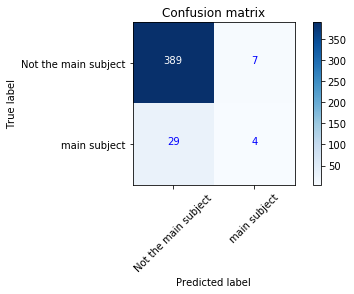

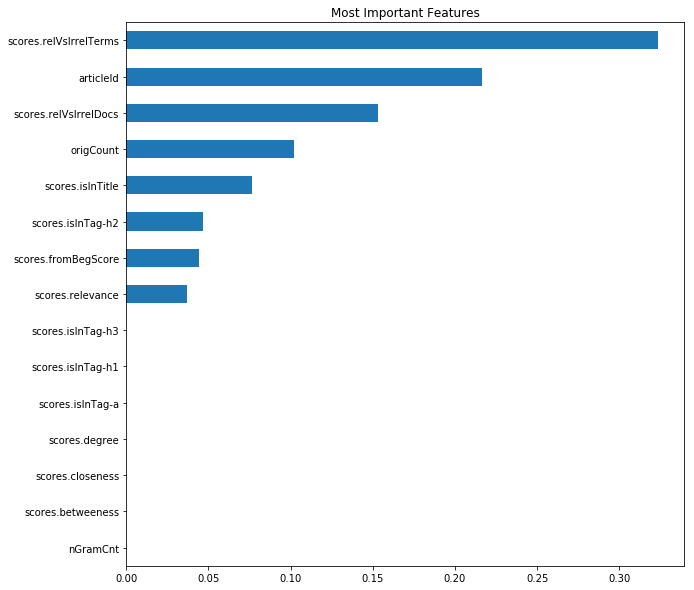

Logistic Regression
--------------The model's accuracy is: 0.76012 
--------------The model's accuracy is: 0.76012 
----------------The Prediction's accuracy is: 0.92308 


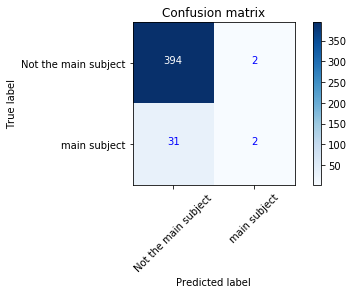

Random Forest
--------------The model's accuracy is: 0.79443 
--------------The model's accuracy is: 0.79443 
----------------The Prediction's accuracy is: 0.91608 


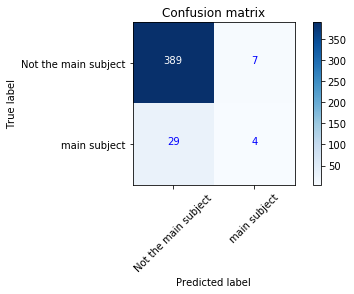

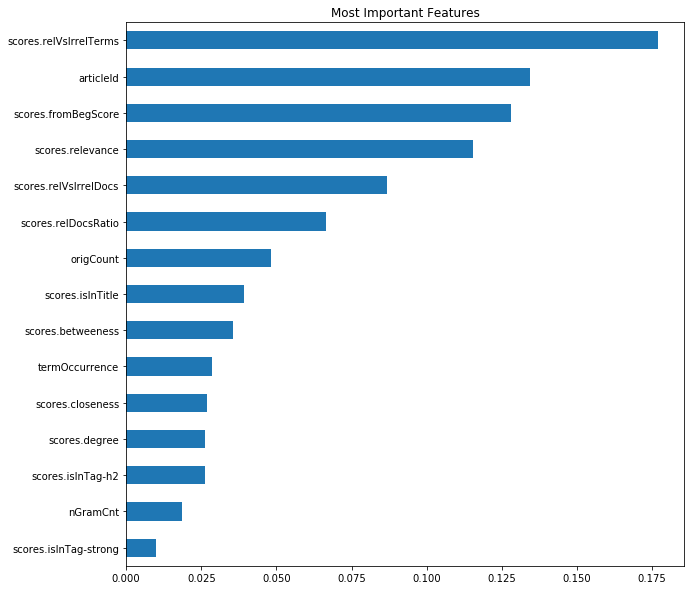

KNN
--------------The model's accuracy is: 0.72038 
--------------The model's accuracy is: 0.72038 
----------------The Prediction's accuracy is: 0.92308 


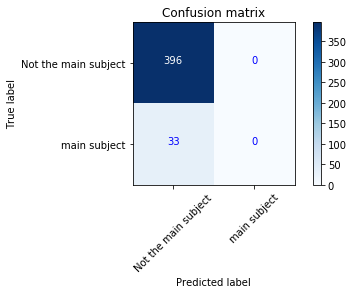

XGBoost
--------------The model's accuracy is: 0.81484 
--------------The model's accuracy is: 0.81484 
----------------The Prediction's accuracy is: 0.91841 


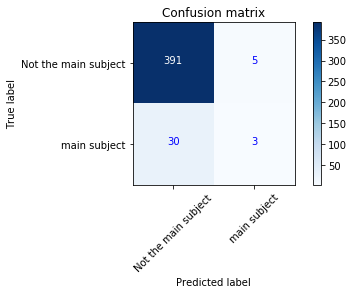

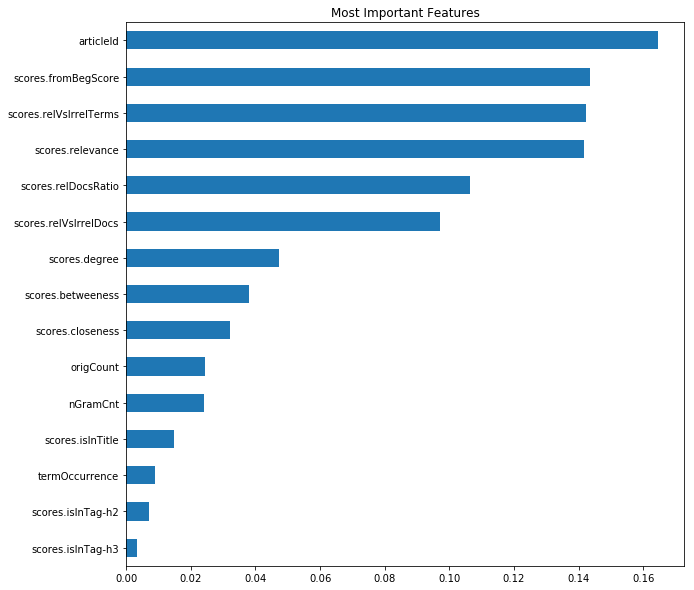

SVM-Linear
--------------The model's accuracy is: 0.58463 
--------------The model's accuracy is: 0.58463 
----------------The Prediction's accuracy is: 0.92308 


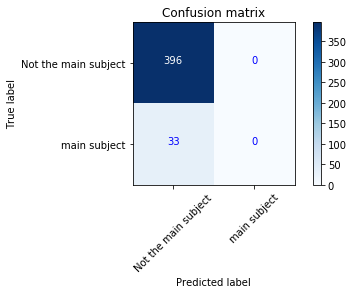

In [243]:
modeling_results= scoreboard(models, classifiers, X_train, X_test, y_train, y_test)
modeling_res = modeling_results[0]
clfs =  modeling_results[1]

In [244]:
topModles = pd.DataFrame.from_dict(modeling_res, orient= 'index').rename(columns = {0 : 'Accuracy score',1: 'Precision'}).sort_values(by='Precision',ascending=False)
topModles                                                                                                                                      

,Accuracy score,Precision
Decision Tree,0.916084,0.121212
Random Forest,0.916084,0.121212
XGBoost,0.918415,0.090909
Logistic Regression,0.923077,0.060606
KNN,0.923077,0.000000
SVM-Linear,0.923077,0.000000


Now all we have is to take our top model, and since the data we have is not a lot I will retrain the model on the entire data set, and fit it to the test set.

In [245]:
topClf = clfs[topModles.iloc[0].name]

def final_fit(sets):
    scaled = []
    for df in sets:
        if 'isCategory' in df.columns:
            df = df.drop('isCategory',axis =1)
        scaled.append((StandardScaler().fit_transform(df)))
    return scaled
scaled = final_fit(datasets)
test['isCategory'] = pd.Series(topClf.fit(scaled[0],train['isCategory']).predict(scaled[1]))



In [252]:
mpath = os.path.normpath(input('Please enter a path'))
test.to_pickle(mpath)

### Summary

This project was a classification project, in my opinion linked to an NLP project, but was mainly a binary classification project.

I started by looking at the data and realized that the main challenge was how to deal with filling the null values since there were many of them and they are not necessarily not needed.

I will now describe the stages of the analysis:
1. I looked at the number of null values. I tried to see how many were counts features there are, and as a result, I replaced the null values with 0. 
2. I plotted the continuous features' values using histogram to learn about their distribution and saw that the distribution of these features looks very much like Gamma/Erlang distribution. Due to that fact, I decided to go ahead and fill the missing values using the mean of each feature column, so the variance is preserved.
3. I was trying to spot outliers among the continuous variables, using boxplot first. However, I saw that most of the outliers are somehow correlated, and many outliers' observations appeared in the same row. Due to that, I decided to leave the outliers in place as they are.
4. After filling in the null values, I split the train data set into train and test using 3:1 ratio. Had it been a larger data set, I may have been able to tip the scales more into the test set and enlarge it, but I think this ratio was ok given the circumstances.
5. Once I filled the null values, I rechecked the relevance of each feature using a correlation matrix, and then wrote a function to remove all features with high correlation over 90%
6. After scaling, I ran gridsearchcv on few classification models, in order to optimize each one and then predict with the optimal values to reach the best prediction. Since we had less than 10% true labels, I figured that the higher the true positive ratio is, better the prediction.
7. I decided to create a data frame which ranks the classifiers according to their precision rate, and in take the top classifier from a dictionary that holds the best estimator. 
8. Due to the shortage of data, I decided to retrain the classifier on the full training set and use the train classifier to predict the value of the test data set.
9. The final data set will be downloaded into a pickle file of the users' choice

## Conclusions

The main issue with the data set as I see it, was the shortage of true values. I believe that if I had more data, the precision rate, which is in my opinion the better way to measure the model's accuracy in this problem, would be higher.

I don't know where the data came from and how the features were calculated. I believe that more thought is needed in order to produce more features that are not correlated with the current ones and may add more information for the model.

Naturally, the runtime of the classifiers is not suitable for production environment since the classifier should be ready. Therefor only the chosen classifier has to be sent to the production environment from a server that runs in parallel.

## Thank you
